In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from scipy import stats

import acquire as ac
import prepare as pr

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = ac.get_telco_data()
train, validate, test = pr.prep_telco(df)
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (4218, 21)
validate shape = (1407, 20)
    test shape = (1407, 20)


In [3]:
def encode_churn(train, validate, test):
    encoder = LabelEncoder()
    encoder.fit(train[["churn"]])
    train["churn_encoded"] = encoder.transform(train[["churn"]])
    validate["churn"] = encoder.transform(validate[["churn"]])
    test["churn"] = encoder.transform(test[["churn"]])
    return encoder, train, validate, test

In [4]:
encoder, train, validate, test = encode_churn(train, validate, test)

In [5]:
# encoder = LabelEncoder()
# encoder.fit(train[["churn"]])
# train["churn_encoded"] = encoder.transform(train.churn)
# validate["churn"] = encoder.transform(validate.churn)
# test["churn"] = encoder.transform(test.churn)

In [6]:
train.head()

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years,churn_encoded
5767,6885-PKOAM,Female,0,71,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),85.75,6223.80,No,Multiple lines,Partner,TV and movies,Security and backup,6.0,0
601,4923-ADWXJ,Female,0,25,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),65.80,1679.65,No,Single line,Single,Movies,Backup,2.0,0
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,No,Single line,Partner and dependents,No internet service,No internet service,0.0,0
5729,6374-AFWOX,Male,0,46,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,65.65,3047.15,No,Single line,Partner,None,Security and backup,4.0,0
1163,9489-UTFKA,Male,1,8,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),60.90,551.95,No,Single line,Partner,TV,Security,1.0,0


---
# Explore

### 1. If a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?

$H_0$: The churn rate for customers whose tenure is less than or equal to one year is the same as all other customers

$H_a$: The churn rate for customers whose tenure is less than or equal to one year is different than all other customers

In [7]:
alpha = .001

x = train[train.tenure_years <= 1].churn_encoded
mu = train.churn_encoded.mean()

tstat, p = stats.ttest_1samp(x, mu)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

t statistic = 14.767252115963558
    p-value = 2.5543291149045378e-46

Reject the null hypothesis


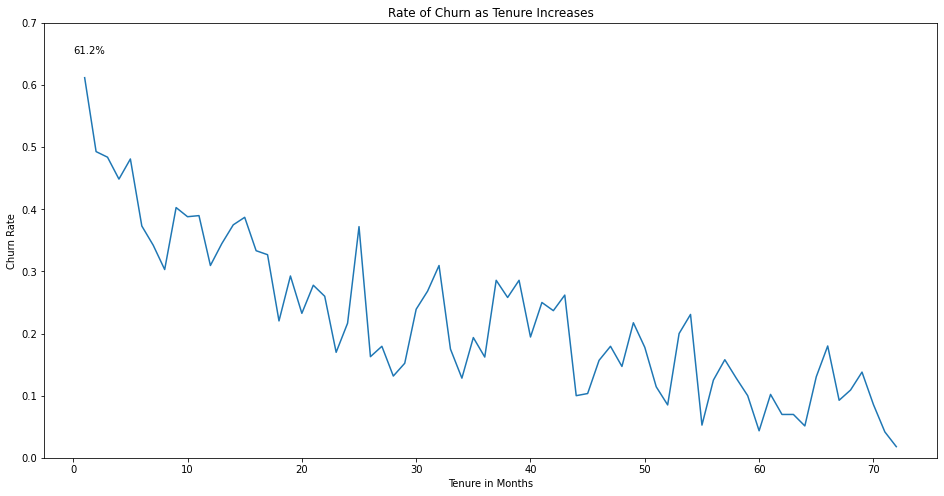

In [8]:
# plotting churn rate by tenure months
monthly = pd.DataFrame({
    "tenure": np.sort(train.tenure.unique()),
})

monthly["churn_rate"] = [((train.churn_encoded == 1) & (train.tenure == n)).sum() / (train.tenure == n).sum() for n in monthly.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(monthly.tenure, monthly.churn_rate)
plt.text(0, .65, f"{train[train.tenure == 1].churn_encoded.mean():.1%}")
plt.xlabel("Tenure in Months")
plt.ylabel("Churn Rate")
plt.ylim(0, .7)
plt.show()

> **Clearly, the rate of churn declines as the customer's tenure with the company increases.**

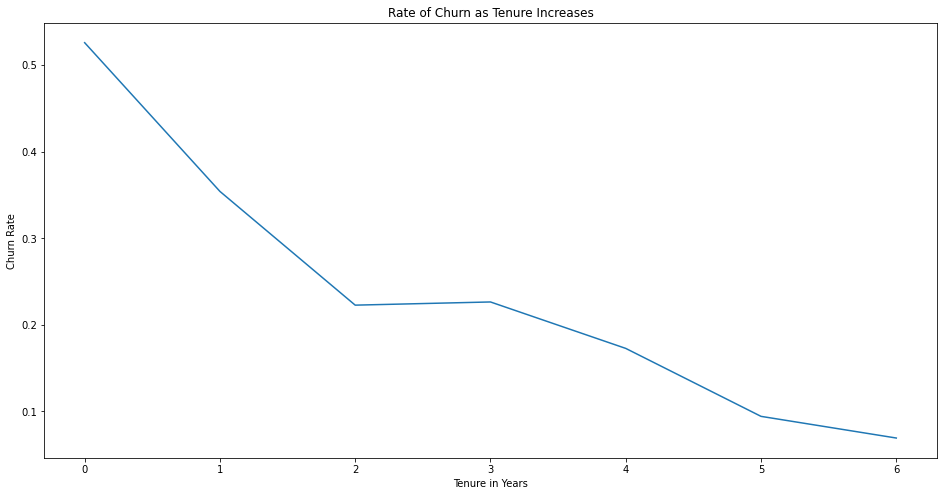

In [9]:
# plotting churn rate by tenure years
yearly = pd.DataFrame({
    "tenure": np.sort(train.tenure_years.unique()),
})

yearly["churn_rate"] = [((train.churn_encoded == 1) & (train.tenure_years == n)).sum() / (train.tenure_years == n).sum() for n in yearly.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(yearly.tenure, yearly.churn_rate)
plt.xlabel("Tenure in Years")
plt.ylabel("Churn Rate")
plt.show()

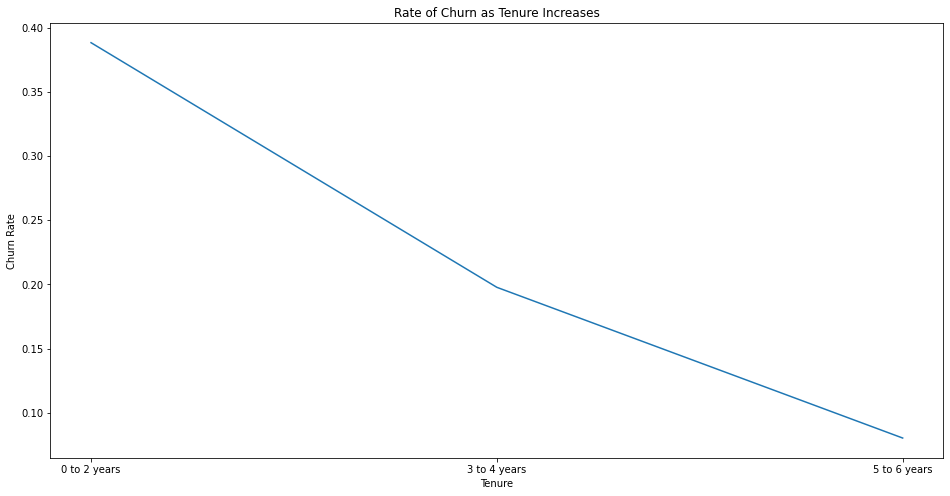

In [10]:
# plotting churn rate by tenure years binned
train["tenure_years_binned"] = pd.cut(train.tenure_years, bins=3, labels=["0 to 2 years", "3 to 4 years", "5 to 6 years"])

binned = pd.DataFrame({
    "tenure": np.sort(train.tenure_years_binned.unique()),
})

binned["churn_rate"] = [((train.churn_encoded == 1) & (train.tenure_years_binned == b)).sum() / (train.tenure_years_binned == b).sum() for b in binned.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(binned.tenure, binned.churn_rate)
plt.xlabel("Tenure")
plt.ylabel("Churn Rate")
plt.show()

### 2. Are there features that indicate a higher propensity to churn? 

#### Churn Rate by Internet Service Type

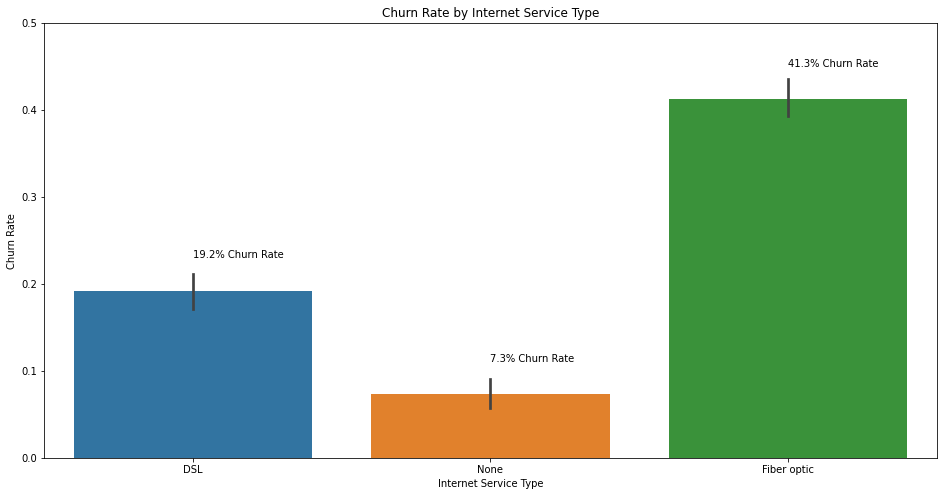

In [11]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Internet Service Type")
sns.barplot(train.internet_service_type, train.churn_encoded)
plt.text(0, .23, f"{train[train.internet_service_type == 'DSL'].churn_encoded.mean():.1%} Churn Rate")
plt.text(1, .11, f"{train[train.internet_service_type == 'None'].churn_encoded.mean():.1%} Churn Rate")
plt.text(2, .45, f"{train[train.internet_service_type == 'Fiber optic'].churn_encoded.mean():.1%} Churn Rate")
plt.xlabel("Internet Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, .5)
plt.show()

> Fiber optic internet service type seems to be a driver of churn. 41.3% of the customers with fiber optic internet service are likely to churn.

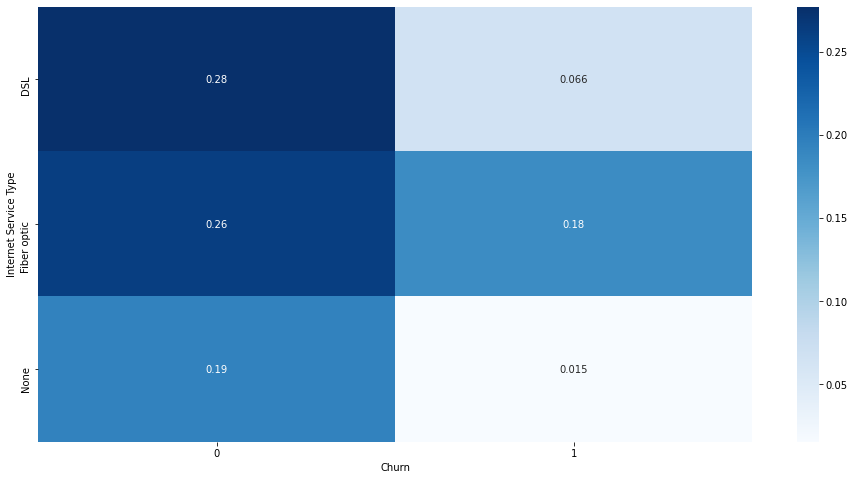

In [12]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.internet_service_type, columns=train.churn_encoded, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Internet Service Type")
plt.show()

> **Customers who are using fiber optic internet service and have churned make up 18% of all customers.**

---
#### Churn Rate by Phone Service Type

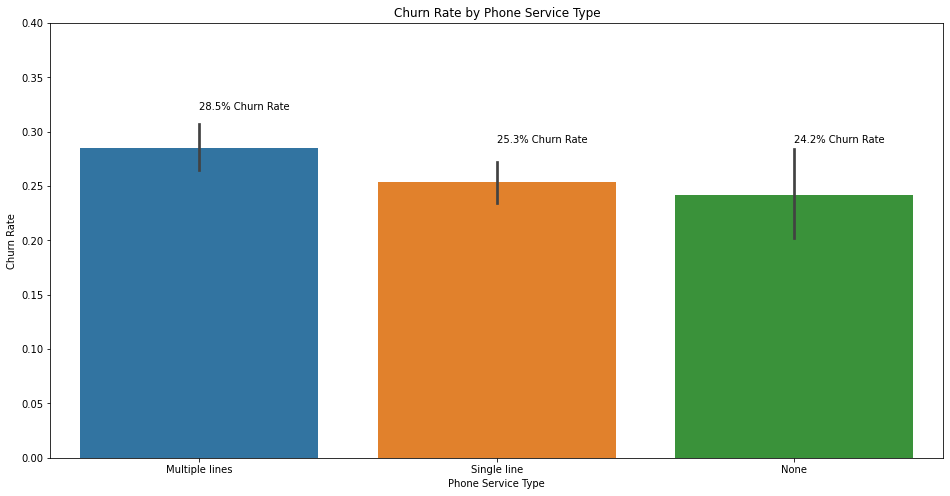

In [13]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Phone Service Type")
sns.barplot(train.phone_service_type, train.churn_encoded)
plt.text(0, .32, f"{train[train.phone_service_type == 'Multiple lines'].churn_encoded.mean():.1%} Churn Rate")
plt.text(1, .29, f"{train[train.phone_service_type == 'Single line'].churn_encoded.mean():.1%} Churn Rate")
plt.text(2, .29, f"{train[train.phone_service_type == 'None'].churn_encoded.mean():.1%} Churn Rate")
plt.xlabel("Phone Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, .4)
plt.show()

> **There does not seem to be a significant difference in the churn rate when considering the phone service type**

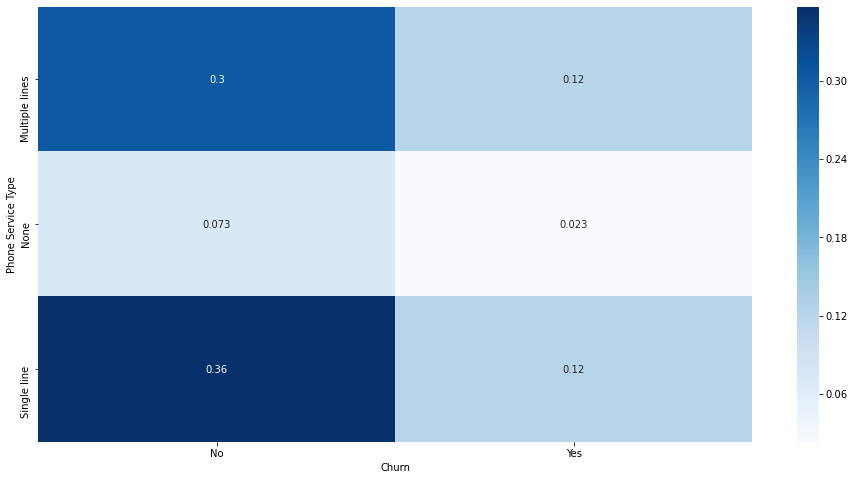

In [14]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.phone_service_type, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Phone Service Type")
plt.show()

---
#### Churn Rate by Online Protection

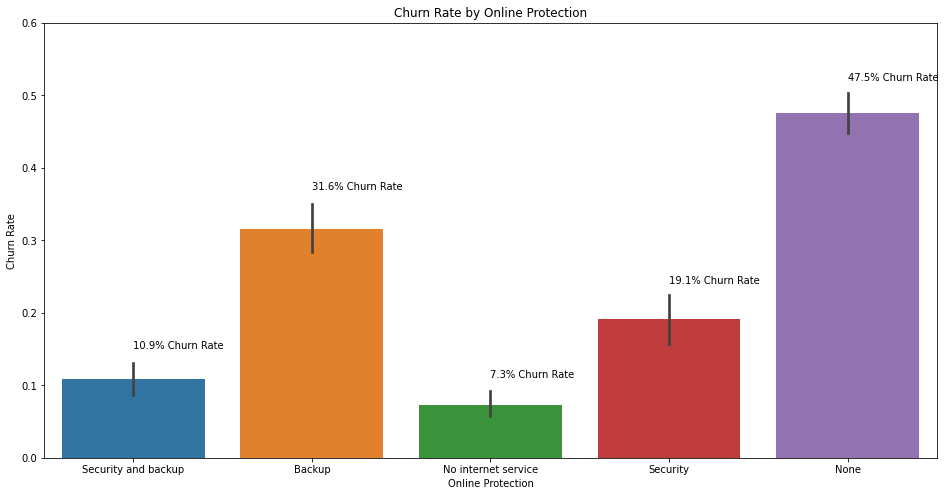

In [15]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Online Protection")
sns.barplot(train.online_protection, train.churn_encoded)
plt.text(0, .15, f"{train[train.online_protection == 'Security and backup'].churn_encoded.mean():.1%} Churn Rate")
plt.text(1, .37, f"{train[train.online_protection == 'Backup'].churn_encoded.mean():.1%} Churn Rate")
plt.text(2, .11, f"{train[train.online_protection == 'No internet service'].churn_encoded.mean():.1%} Churn Rate")
plt.text(3, .24, f"{train[train.online_protection == 'Security'].churn_encoded.mean():.1%} Churn Rate")
plt.text(4, .52, f"{train[train.online_protection == 'None'].churn_encoded.mean():.1%} Churn Rate")
plt.xlabel("Online Protection")
plt.ylabel("Churn Rate")
plt.ylim(0, .6)
plt.show()

> **47.5% of the customers that have no online protection churn.**

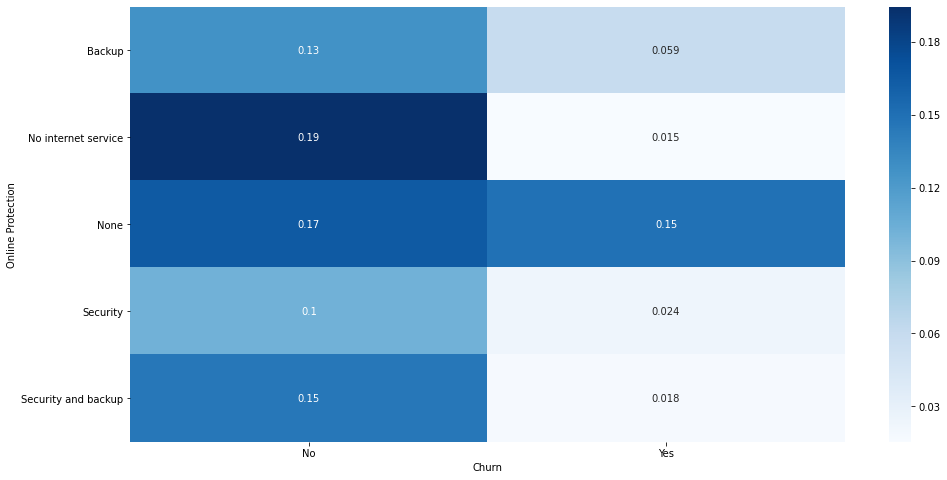

In [16]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.online_protection, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Online Protection")
plt.show()

> **Customers who have no online protection plan and who have churned make up 15% of all customers.**

---
#### Churn Rate by Senior Citizen Status

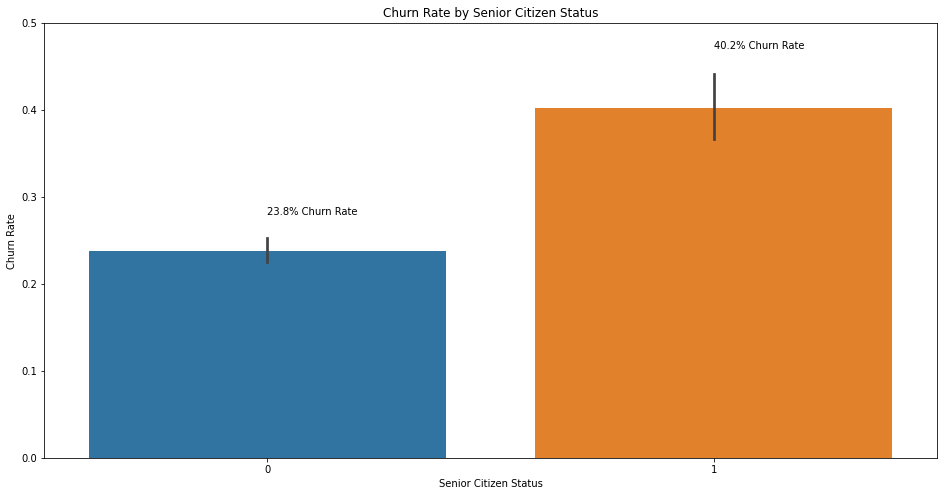

In [17]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Senior Citizen Status")
sns.barplot(train.senior_citizen, train.churn_encoded)
plt.text(0, .28, f"{train[train.senior_citizen == 0].churn_encoded.mean():.1%} Churn Rate")
plt.text(1, .47, f"{train[train.senior_citizen == 1].churn_encoded.mean():.1%} Churn Rate")
plt.xlabel("Senior Citizen Status")
plt.ylabel("Churn Rate")
plt.ylim(0, .5)
plt.show()

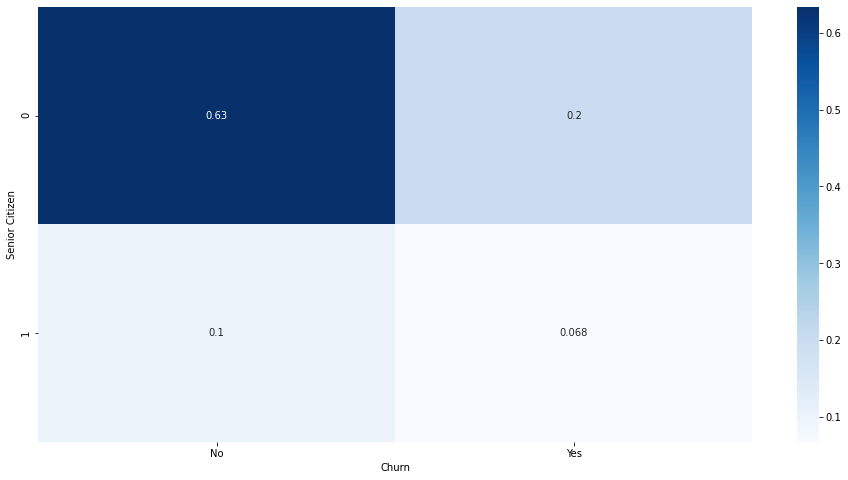

In [18]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.senior_citizen, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Senior Citizen")
plt.yticks?
plt.show()

> **Customers who are not senior citizens and who have churned make up 20% of all customers.**

---
### 3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [19]:
# for t in train.internet_service_type.unique():
#     plt.title(f"Rate of Churn as Monthly Charges Increase for {t}")
#     sns.scatterplot(train.monthly_charges, train.churn_encoded)
#     plt.xlabel("Monthly Charges in Dollars")
#     plt.ylabel("Churn Rate")
#     plt.show()

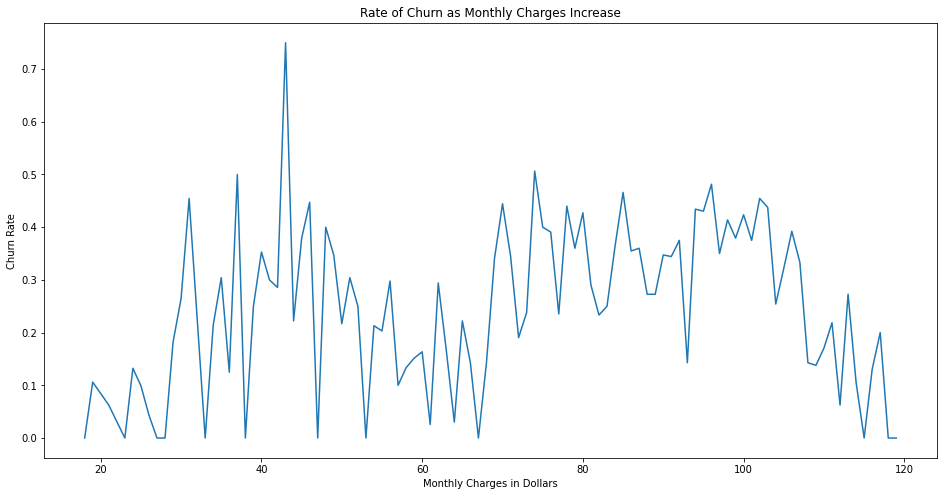

In [20]:
# plotting churn rate by monthly_charges
monthly_charges = pd.DataFrame({
    "charges": np.sort(train.monthly_charges.round().unique()),
})

monthly_charges["churn_rate"] = [((train.churn_encoded == 1) & (train.monthly_charges.round() == n)).sum() / (train.monthly_charges.round() == n).sum() for n in monthly_charges.charges]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Monthly Charges Increase")
plt.plot(monthly_charges.charges, monthly_charges.churn_rate)
plt.xlabel("Monthly Charges in Dollars")
plt.ylabel("Churn Rate")
plt.show()

In [21]:
# # plotting churn rate by monthly_charges
# dsl_monthly_charges = pd.DataFrame({
#     "charges": np.sort(train[train.internet_service_type == "DSL"].monthly_charges.round().unique()),
# })

# monthly_charges["churn_rate"] = [((train.churn_encoded == 1) & (train.monthly_charges.round() == n)).sum() / (train.monthly_charges.round() == n).sum() for n in dsl_monthly_charges.charges]

# plt.figure(figsize=(16, 8))

# plt.title("Rate of Churn as Monthly Charges Increase")
# plt.plot(dsl_monthly_charges.charges, dsl_monthly_charges.churn_rate)
# plt.xlabel("Monthly Charges in Dollars")
# plt.ylabel("Churn Rate")
# plt.show()

In [22]:
monthly_charges.groupby("churn_rate").max()

,charges
churn_rate,
0.000000,119.0
0.025641,61.0
0.030303,64.0
0.043478,26.0
0.062500,112.0
...,...
0.465909,85.0
0.481481,96.0
0.500000,37.0


### 4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

$H_0$: The churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month is the same

$H_a$: The churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month is different

In [23]:
alpha = .001

month_to_month = train[(train.contract_type == "Month-to-month") & (train.tenure > 12)].churn_encoded
annual = train[(train.contract_type == "One year") & (train.tenure > 12)].churn_encoded

tstat, p = stats.ttest_ind(month_to_month, annual)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")
print()
print(f"The churn rate for month-to-month customers after the 12th month is {month_to_month.mean():.1%}")
print(f"The churn rate for 1-year contract customers after the 12th month is {annual.mean():.1%}")
print()
print("""It can be stated with 99.9% certainty that month-to-month customers after the 12th month churn at almost
3x the rate of 1-year contract customers after the 12th month.

Takeaway: If we are trying to reduce churn, we should be more aggressive in contract aquisition""")

t statistic = 10.939201115216212
    p-value = 4.6357843354484826e-27

Reject the null hypothesis

The churn rate for month-to-month customers after the 12th month is 33.0%
The churn rate for 1-year contract customers after the 12th month is 11.8%

It can be stated with 99.9% certainty that month-to-month customers after the 12th month churn at almost
3x the rate of 1-year contract customers after the 12th month.

Takeaway: If we are trying to reduce churn, we should be more aggressive in contract aquisition
